In [10]:
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd
import numpy as np

# Set up the plotting template
pio.templates["custom"] = pio.templates["plotly"]
pio.templates["custom"].layout.margin = dict(l=0, r=0, t=50, b=0)
pio.templates.default = "custom"

**Note**: This notebook usually a single reference book for all of the concepts, images, and equations listed here. However, individual references are placed throughout the notebook to point the reader to the exact pages where the material was sourced from the reference.

# Convolution

Convolution is a mathematical way of combining two signals, and it provides the framework for DSP. It is a mathematical operator in the same way that addition, multiplication, and integration are operators. Some background is needed before diving into the convolution operation.

## Background - Impulses

An impulse is a discrete set of zero-points with a single non-zero point at some index in the set. The delta function, denoted $\delta [n]$ (also known as the **unit impulse**), is a normalized impulse (i.e., the non-zero point has a value of 1 at $n=0$). The term **impulse response** refers to the response of some system (e.g., a filter) when the input to that system is a delta function. The impulse response is usually denoted as $h[n]$.

Any discrete signal can be represented as a set of *scaled* and *offset* impulses. For example, if I have a signal composed of 5 points $y = [3, 12, 55, -9, 1]$, each point in this signal can be considered a delta function that is scaled by $y[n]$ and shifted by $n$. Consider a signal $a[n]$ that is comprised of a single non-zero point with a value of $y[3]$. Because all points except for one in the signal are zero, it is considered an impulse. In equation form $a[n]$ can be represented as:
$$
a[n] = -9\cdot \delta[n-3]
$$
Understanding that any discrete signal can be represented this way is very important to understanding how the impulse response characterizes a system. If the delta function $\delta[n]$ results in the impulse response $h[n]$ of a given system, then it follows that the input $-9\delta[n-3]$ results in the output $-9h[n-3]$. The output is a version of the impulse response that has been scaled by -9 and shifted by 3. If you know a system's impulse response, you know how the system will react to any input. $^{[1]}$
<center><img src="images/impulse_response.png"></center>

## The Fun Stuff

As mentioned before, convolution is a mathematical operation. An operation such as addition takes two numbers as inputs and produces a third as an output. Convolution takes two input signals and produces an output signal. It is a commutative operation in the same way that addition and multiplication are ($h[n]$ convolved with $x[n]$ is the same thing as $x[n]$ convolved with $h[n]$).

The symbol that represents convolution is the star operator:
$$
y[n] = x[n] \star h[n]
$$
The input signal may be hundreds, thousands, or millions of points long. Typically, the impulse response will be on the order of tens or a few hundred points long. The length of the output signal depends on the length of the input and the impulse response. Specifically, the length of the output signal is the length of the input, plus the length of the output, minus one$^{[2]}$. It will become more clear why that is when we go over the process of convolving two signals.

There are two ways to describe the characteristics of the convolution operation: the input side algorithm, and the output side algorithm, as termed by the author of the reference book. The input side algorithm is useful in visualizing the process of convolution, while the output side algorithm is more in-line with the mathematical expression for the convolution sum (described later on).

### The Input Side Algorithm

This method of analyzing the process of convolution involves decomposing the input signal into impulses and passing them through the impulse response $h[n]$. To do this we look at each sample in the input signal and see how it affects the output. Each of the responses from the scaled and shifted impulses contribute to the final values of the points in the output signal $y[n]$. This particular viewpoint is useful in understanding how each sample in the input $x[n]$ affects many samples in the output signal $y[n]$  $^{[3]}$.

Let's say we have a 9 point input signal $x[n]$ and we want to convolve it with a 4 point impulse response $h[n]$:

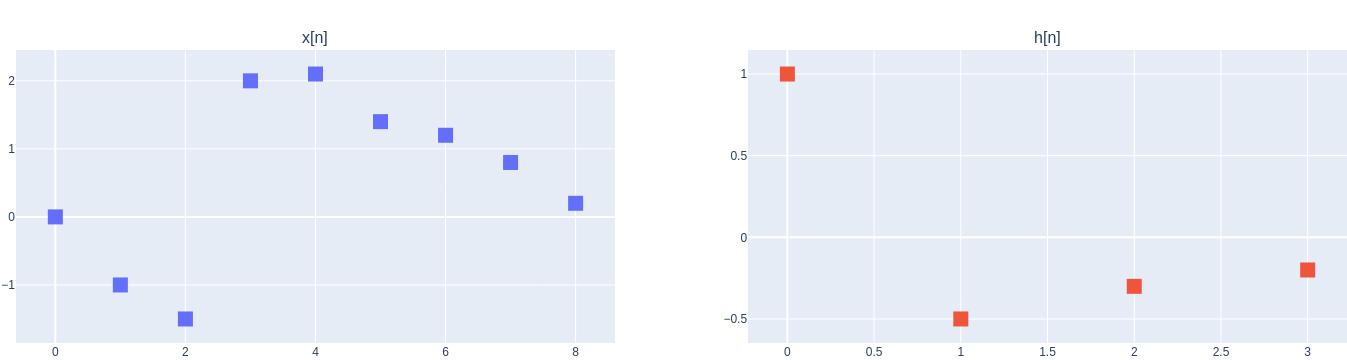

In [17]:
x = np.array([0, -1, -1.5, 2, 2.1, 1.4, 1.2, 0.8, 0.2])
h = np.array([1, -0.5, -0.3, -0.2])
fig = make_subplots(rows=1, cols=2, subplot_titles=("x[n]", "h[n]"))
fig.add_trace(go.Scatter(x=np.array(range(len(x))), 
                         y=x,
                         marker=dict(size=15, symbol="square"),
                         mode="markers",
                         showlegend=False),
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(len(h))), 
                         y=h, 
                         marker=dict(size=15, symbol="square"),
                         mode="markers",
                         showlegend=False),
              row=1, col=2)
fig.show()

$x[0]$ is zero, so the contribution from this point will be zero. $x[1] = -1$, so the resulting response from this point should be the shape of the impulse response $h[n]$, inversed and shifted by 1. $x[2] = -1.5$, so the response contribution from this point will be scaled by -1.5 and shifted by 2, and so on. Each of these contributions are then summed up to produce the output signal $y[n]$.

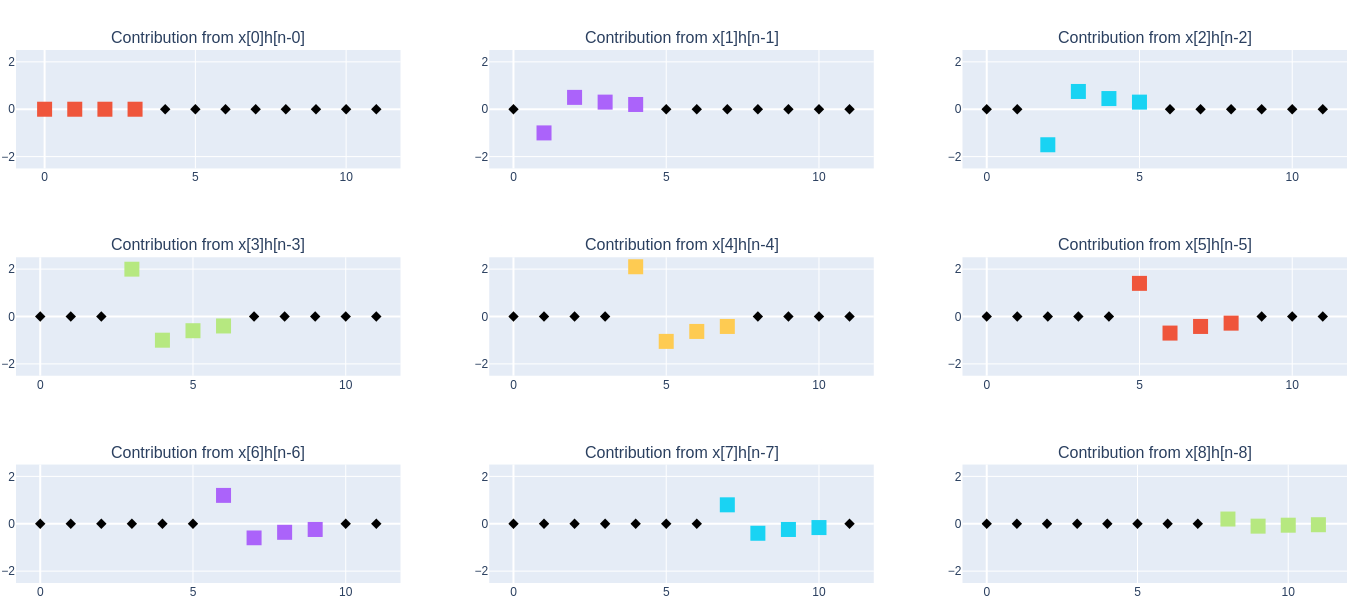

In [15]:
"""
This function does not compute the actual convolution of
the signals x and h. Instead it returns the contributions of
the impulse of x[n] passed through the impulse response h[n].
It also returns the indices of each affected and non-affected
value in the total y signal so they can be easily marked on the
plots.
"""
def input_side_alg(x, h, n):
    y = np.zeros(len(x) + len(h) - 1)
    y[n:n+len(h)] = x[n] * h
    zeros    = [i for i in range(len(y)) if i not in range(n,n+len(h))]
    nonzeros = [i for i in range(len(y)) if i in range(n,n+len(h))]
    return y[n:n+len(h)], zeros, nonzeros

fig = make_subplots(rows=3, cols=3, 
                    subplot_titles=( [f"Contribution from x[{i}]h[n-{i}]" for i in range( len(x) )] ) )
for i in range(len(x)):
    y,zero_inds,nonzero_inds = input_side_alg(x, h, i)
    
    # Plot the zero points as diamonds
    zeros = go.Scatter(x=zero_inds,
                       y=np.zeros(len(zero_inds)),
                       marker=dict(size=8, symbol="diamond", color="black"),
                       mode="markers",
                       showlegend=False)
    fig.add_trace(zeros, row=int(np.floor((i+3)/3)), col=(i%3)+1)

    # Plot the non-zero points as squares
    nonzeros = go.Scatter(x=nonzero_inds,
                          y=y,
                          marker=dict(size=15, symbol="square"),
                          mode="markers",
                          showlegend=False)
    fig.add_trace(nonzeros, row=int(np.floor((i+3)/3)),  col=(i%3)+1)

fig.update_layout(height=600)
fig.update_yaxes(range=[-2.5, 2.5])
fig.show()

The final signal $y[n]$ is the sum of each point. For instance, $y[3]$ is the sum of all $x$ contributions in the 9 plots above at point $n=3$.

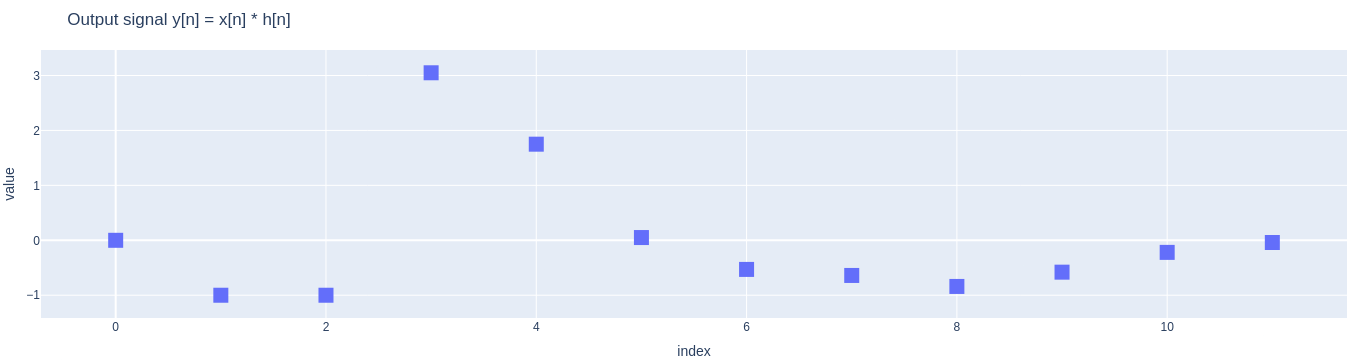

In [16]:
contribs = [input_side_alg(x, h, i)[0] for i in range(len(x))]
y = np.zeros(len(x) + len(h) - 1)
for i in range(len(x)):
    y[i:i+len(h)] += contribs[i]

fig = px.scatter(y)
fig.update_traces(marker=dict(size=15, symbol="square"))
fig.update_layout(title="Output signal y[n] = x[n] * h[n]", showlegend=False)
fig.show()

### The Output Side Algorithm

The Output Side Algorithm is a more practical viewpoint from a mathematical perspective (i.e., when looking at the equation for the Convolution Sum). This second viewpoint involves a reversal of the first viewpoint, where we look at the output signal and find the contributing components of the input signal. $^{[4]}$

Let's examine the 7th point in the output signal, $y[6]$. We know that this point is the sum of all contributions from the input signal, $x[n]$. Specifically, it is the sum of all *seventh* points in the 9 component plots shown above. Notice that 5 out of the 9 plots have zero contributions to $y[6]$, denoted by diamond markers. The only samples from the input signal that contribute to this point are $x[3], x[4], x[5],$ and $x[6]$. The 7th point in $y$ is calculated as:
$$
y[6] = x[3]h[3] + x[4]h[2] + x[5]h[1] + x[6]h[0]
$$
We can generalize this equation for each point of $y$. Enter the Convolution Sum.

### The Convolution Sum

The Convolution Sum for discrete signals is:
$$
y[i] = \sum_{j=0}^{M-1}h[j]\ x[i-j]
$$
where $M$ is the length of the impulse response $h[j]$. In words, the value of the $i$th point in $y$ is the sum of the impulse response at point $j$ times the input signal $x[i-j]$, across all points from $j=0\to M-1$. The index $j$ runs to $M-1$ because we are using a starting index of 0.

What happens when we are calculating $y[0]$ and the $j$ index hits 1? We can't index $x[-1]$ - same with $x[-2], x[-3]$, etc. These samples don't exist. The same issue arises when $i$ reaches values outside of the range of $x$, since the length of $y$ is larger than $x$.

The solution is to pad the arrays with zeros for the out-of-bounds indices. Zero-padding the samples is effectively ignoring the non-existant samples. The code below takes zero-padding into consideration by skipping the invalid indices.

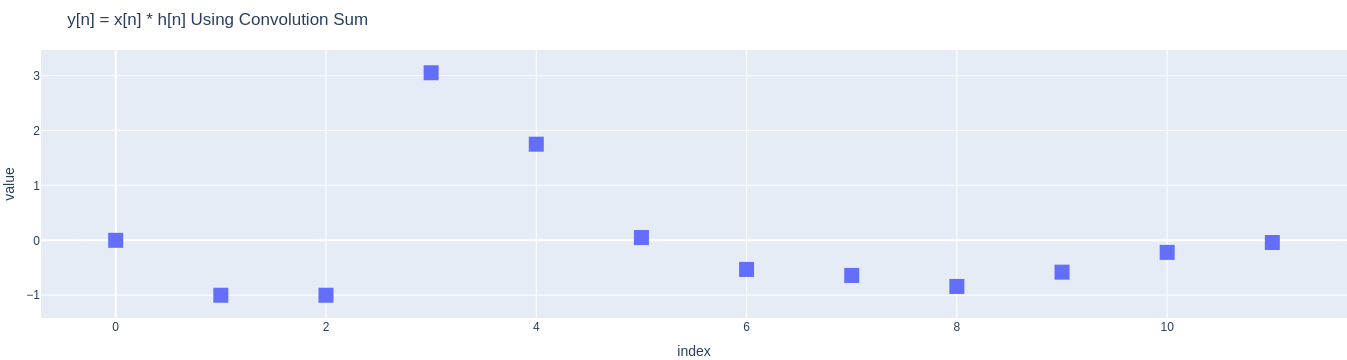

In [14]:
"""
Convolve x[n] with h[n] using the convolution sum
"""
def convolve(h, x):
    y = np.zeros(len(x) + len(h) - 1)
    for i in range(len(y)):
        for j in range(len(h)):
            if i - j < 0:
                continue
            elif i - j >= len(x):
                continue
            else:
                y[i] += h[j]*x[i-j]
    return y

fig = px.scatter(convolve(x, h))
fig.update_traces(marker=dict(size=15, symbol="square"))
fig.update_layout(title="y[n] = x[n] * h[n] Using Convolution Sum", showlegend=False)
fig.show()

# References

[1] Smith, Steven W. (1999). Ch 6 Convolution. *Guide to Digital Signal Processing* (2nd ed., pp 108-109)\
[2] Smith, Steven W. (1999). Ch 6 Convolution. *Guide to Digital Signal Processing* (2nd ed., pp 111)\
[3] Smith, Steven W. (1999). Ch 6 Convolution. *Guide to Digital Signal Processing* (2nd ed., pp 112)\
[4] Smith, Steven W. (1999). Ch 6 Convolution. *Guide to Digital Signal Processing* (2nd ed., pp 116)
